## EDA Single Sample Hourly

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
sys.path.append(os.getcwd() + "/..")
from utils import plot_correlogram
import feature_engineering as fe
import warnings
from scipy import stats
from sklearn.model_selection import train_test_split
from utils import combine_data
from sklearn.pipeline import make_pipeline
%matplotlib inline
plt.style.use('bmh')
warnings.filterwarnings('ignore')
random_state=123456789
np.random.seed(123456789)
from utils import plot_correlogram

## Read Data

In [2]:
meta, data =pd.read_pickle("../data/forecast_data_2020.p")

In [3]:
homes_indexes = data.columns.get_level_values(0).unique()

In [4]:
homes_indexes

Index(['854', '123', '852', '222', '484', '404', '992', '319', '583', '801',
       '987', '299', '640', '744', '241', '200', '441', '192', '621', '313',
       '464', '424', '993', '598', '514', '268', '745', '927', '945', '352',
       '980', '644', '683', '244', '677', '351', '118', '595', '255', '554',
       '318', '743', '947', '480', '219', '780', '909', '977', '272', '246',
       '521', '842', '267', '396', '290', '601', '901', '260', '618', '629',
       '238', '231', '875', '889', '340', '906', '604', '525', '460', '130',
       '363', '250', '666', '438', '986', '462', '188', '763', '923', '925',
       '822', '131', '456', '624', '827', '474', '859', '912', '194', '706',
       '522', '999', '113', '247', '657', '890', '412', '261', '957', '600'],
      dtype='object')

## Feature Engineering

### Target
Since at time step T we need to predict the value given at step T+1, but at step T
we only know values from step T-1 (make prediction on Wednesday about Constumption on Thursday, given known values of consumption only at Teusday, thus we need to shift by 2 * 24h = 48h

In [5]:
target = make_pipeline(fe.FeatureSelector('consumption'), fe.CalcShift(-48),fe.CastType(float))

### Current consumption
consumption at step T-1 won't require any shift

In [6]:
prev_consumption = make_pipeline(fe.FeatureSelector('consumption'), fe.CastType(float))

### Weather

Note all weather prediction for T+1 is given at step T, thus we need to shift for 24h

In [7]:
temperature = make_pipeline(fe.FeatureSelector('temperature'), fe.CalcShift(-48), fe.CastType(float))
humidity = make_pipeline(fe.FeatureSelector('humidity'), fe.CalcShift(-48), fe.CastType(float))
cloudiness = make_pipeline(fe.FeatureSelector('cloudiness'), fe.CalcShift(-48), fe.CastType(float))

### Extract Day Time

In [8]:
day_time =  make_pipeline(fe.FeatureSelector('time'), fe.ExtractDayTime())

### Extract Week Day

In [9]:
week_day =  make_pipeline(fe.FeatureSelector('time'), fe.ExtractWeekDay())

### Extract season name from date

In [10]:
season = make_pipeline(fe.FeatureSelector('time'), fe.ExtractSeason())

### Combine Features

In [11]:
feature_union = fe.make_union(prev_consumption,
                              temperature,
                              humidity,
                              cloudiness,
                              day_time,
                              week_day,
                              season,
                              target
                              )
feature_union

PandasFeatureUnion(transformer_list=[('pipeline-1',
                                      Pipeline(steps=[('featureselector',
                                                       FeatureSelector(feature_name='consumption')),
                                                      ('casttype',
                                                       CastType())])),
                                     ('pipeline-2',
                                      Pipeline(steps=[('featureselector',
                                                       FeatureSelector(feature_name='temperature')),
                                                      ('calcshift',
                                                       CalcShift(shift_val=-48)),
                                                      ('casttype',
                                                       CastType())])),
                                     ('pipeline-3',
                                      Pipeline(steps=[('...
                                                       FeatureSelector(feature_name='time')),
                                                      ('extractweekday',
                                                       ExtractWeekDay())])),
                                     ('pipeline-7',
                                      Pipeline(steps=[('featureselector',
                                                       FeatureSelector(feature_name='time')),
                                                      ('extractseason',
                                                       ExtractSeason())])),
                                     ('pipeline-8',
                                      Pipeline(steps=[('featureselector',
                                                       FeatureSelector(feature_name='consumption')),
                                                      ('calcshift',
                                                       CalcShift(shift_val=-48)),
                                                      ('casttype',
                                                       CastType())]))])

## Transform

In [12]:
df_dict = {}
homes_indexes_subsample = np.random.choice(list(map(lambda x: x[0],data.keys())), 30, replace=False)

for home_i in list(homes_indexes_subsample):
    if home_i == "268": # outlier
        continue
    temp_df = data[home_i]
    temp_df["time"] = temp_df.index
    temp_df = feature_union.fit_transform(temp_df)
    temp_df = temp_df.reset_index().drop_duplicates(subset='time', keep="last").set_index("time")
    temp_df["ev"] = meta[home_i]["has_electric_vehicle"] +0
    temp_df["home_num"] = home_i
    
    df_dict[home_i] = temp_df
del temp_df

In [13]:
df = combine_data(df_dict)

In [14]:
df.describe()

,consumption,forward_temperature_48,forward_humidity_48,forward_cloudiness_48,week_day,forward_consumption_48,ev
count,244636.000000,244636.000000,244636.000000,244636.000000,244636.000000,244636.000000,244636.000000
mean,3.207083,8.382298,74.826891,62.984166,2.999886,3.209109,0.785714
std,2.284929,7.083524,19.709095,38.092912,1.999918,2.284970,0.410327
min,0.000000,-13.730000,11.000000,0.000000,0.000000,0.000000,0.000000
25%,1.570000,2.770000,61.000000,26.000000,1.000000,1.571000,1.000000
50%,2.661000,7.320000,80.000000,78.000000,3.000000,2.664000,1.000000
75%,4.230000,13.480000,91.000000,99.000000,5.000000,4.233000,1.000000
max,24.830000,31.540000,100.000000,100.000000,6.000000,24.830000,1.000000


### EDA  Target

Text(0.5, 1.0, 'avg eConsumption')

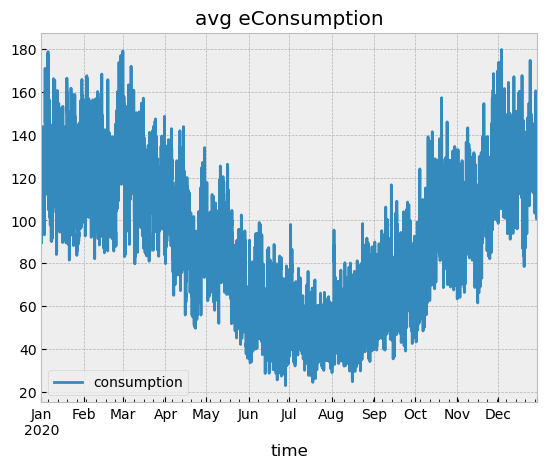

In [15]:
df["consumption"].reset_index().groupby("time").sum().plot(label = "aggregated_by_sum_consumption")
plt.legend()
plt.title("avg eConsumption")

Text(0.5, 1.0, 'eConsumption by home samples')

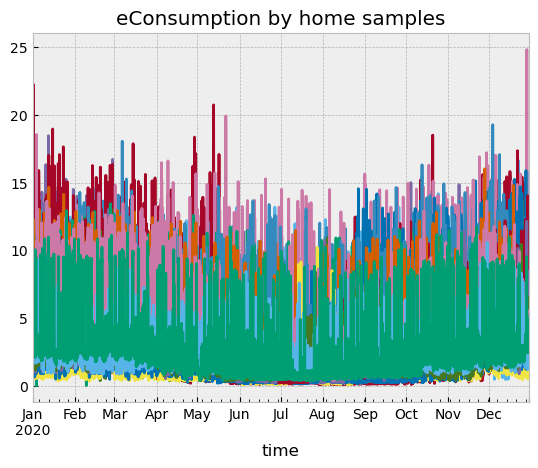

In [16]:
pd.pivot_table(df[["consumption","home_num"]].reset_index(),
               index = "time",
               values="consumption",
               columns="home_num").plot(legend=False)
plt.title("eConsumption by home samples")

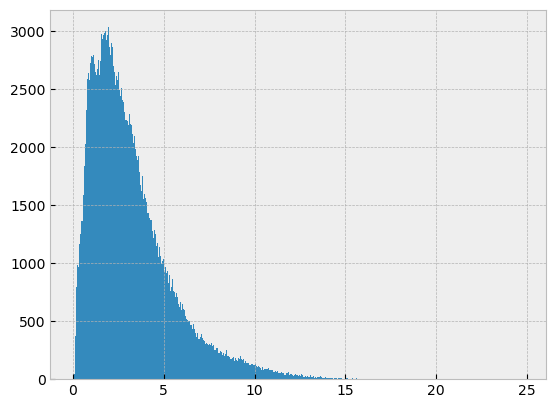

In [17]:
plt.hist(df["forward_consumption_48"], bins = 500)
plt.show()

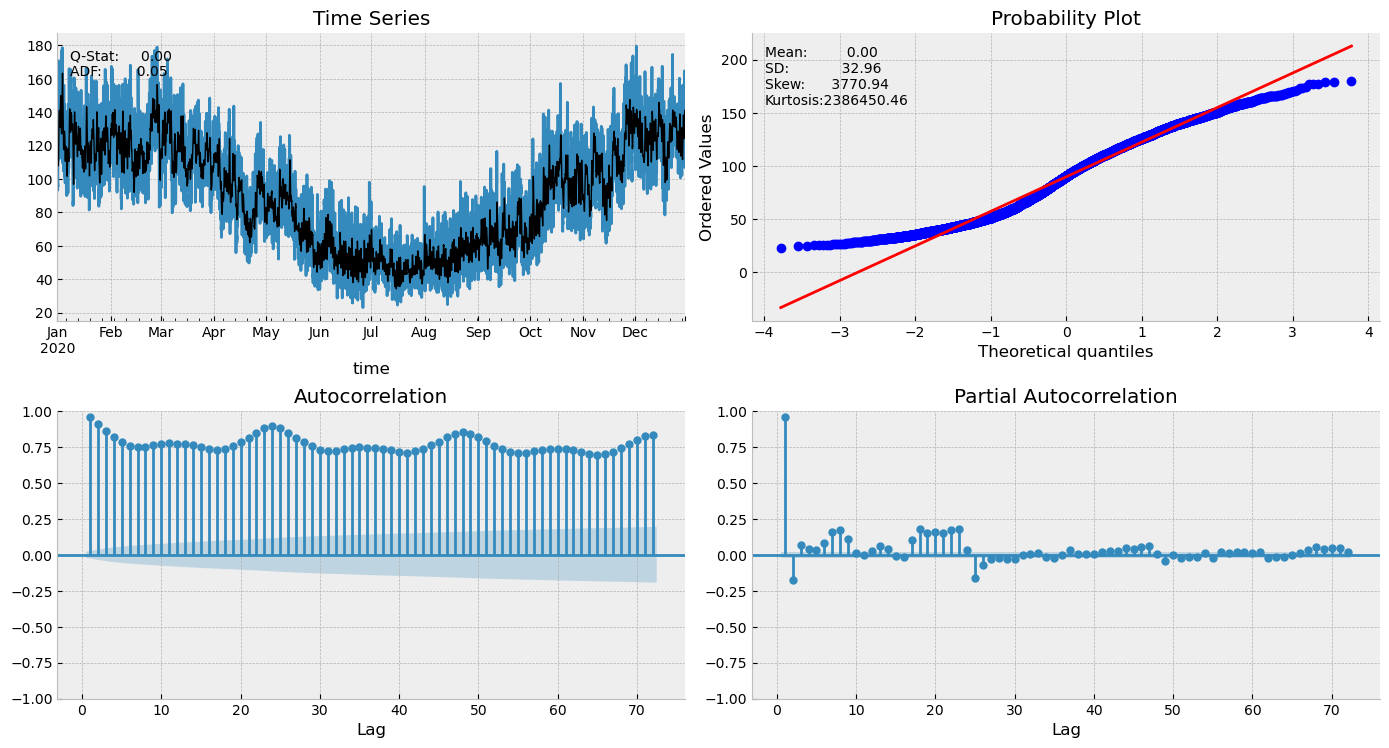

In [18]:
plot_correlogram(df["forward_consumption_48"].reset_index().groupby("time").sum()["forward_consumption_48"], lags = 72)

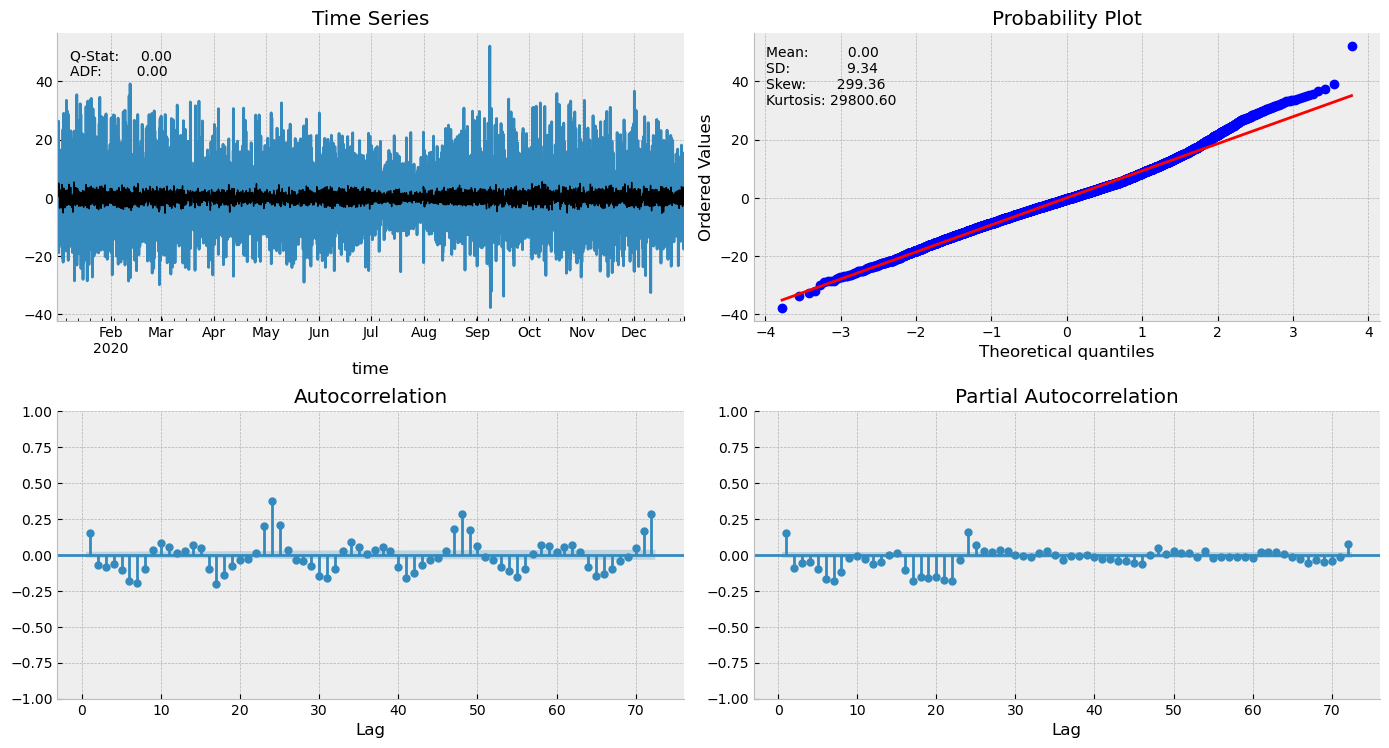

In [19]:
plot_correlogram(df["forward_consumption_48"].reset_index().groupby("time").sum()["forward_consumption_48"].diff().dropna(), lags = 72)

### Features EDA

Text(0.5, 1.0, 'Temperature Forecast by home samples')

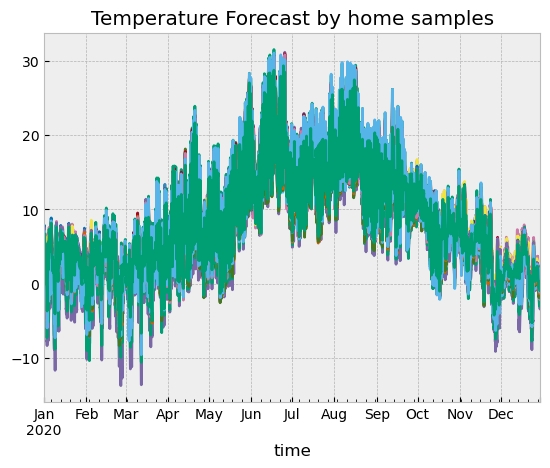

In [21]:
pd.pivot_table(df[["forward_temperature_48","home_num"]].reset_index(),
               index = "time",
               values="forward_temperature_48",
               columns="home_num").plot(legend=False)
plt.title("Temperature Forecast by home samples")

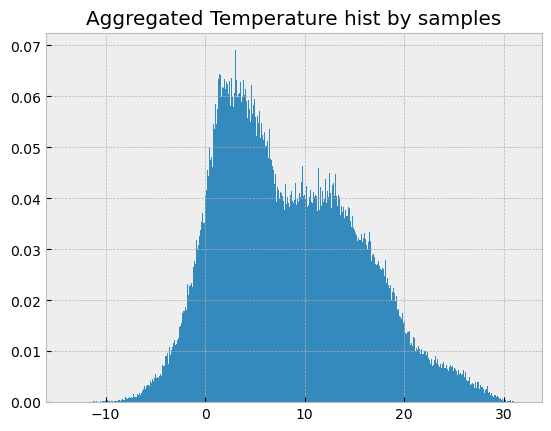

In [22]:
plt.hist(df["forward_temperature_48"], bins = 500, density=True)
plt.title("Aggregated Temperature hist by samples")
plt.show()

Text(0.5, 1.0, 'Humidity Forecast by home samples')

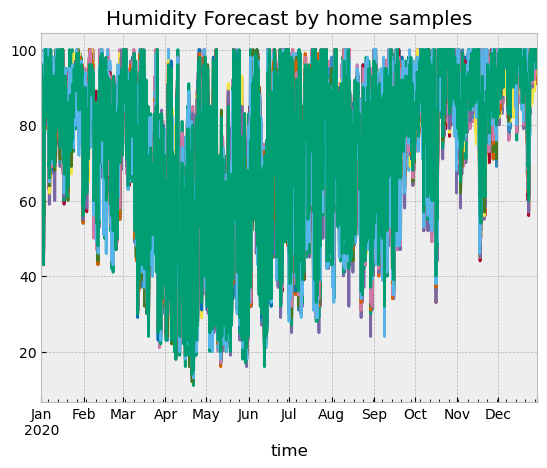

In [24]:
pd.pivot_table(df[["forward_humidity_48","home_num"]].reset_index(),
               index = "time",
               values="forward_humidity_48",
               columns="home_num").plot(legend=False)
plt.title("Humidity Forecast by home samples")

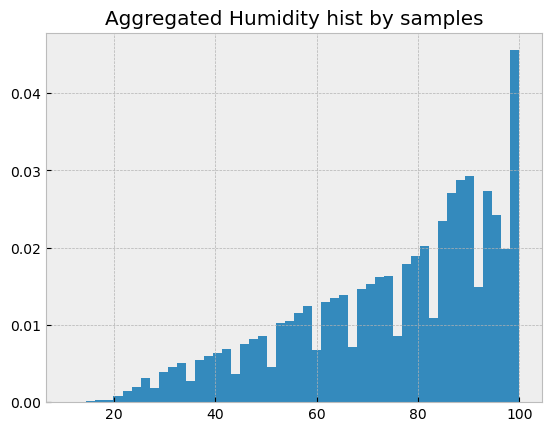

In [25]:
plt.hist(df["forward_humidity_48"], bins = 50, density=True)
plt.title("Aggregated Humidity hist by samples")
plt.show()

Text(0.5, 1.0, 'Cloudiness Forecast by home samples')

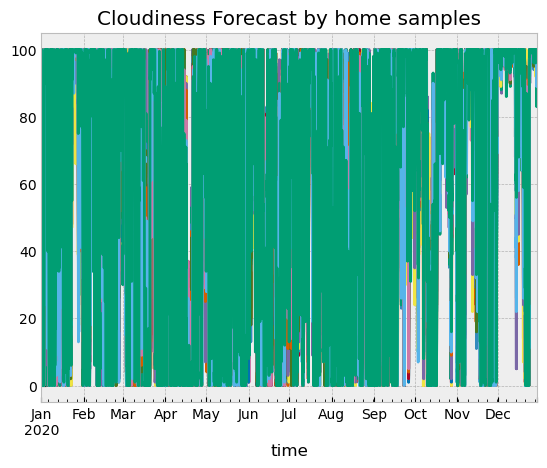

In [26]:
pd.pivot_table(df[["forward_cloudiness_48","home_num"]].reset_index(),
               index = "time",
               values="forward_cloudiness_48",
               columns="home_num").plot(legend=False)
plt.title("Cloudiness Forecast by home samples")

In [1]:
plt.hist(df["forward_cloudiness_48"], bins = 50, density=True)
plt.title("Aggregated cloudines hist by samples")
plt.show()

NameError: name 'plt' is not defined

## Multivariate EDA

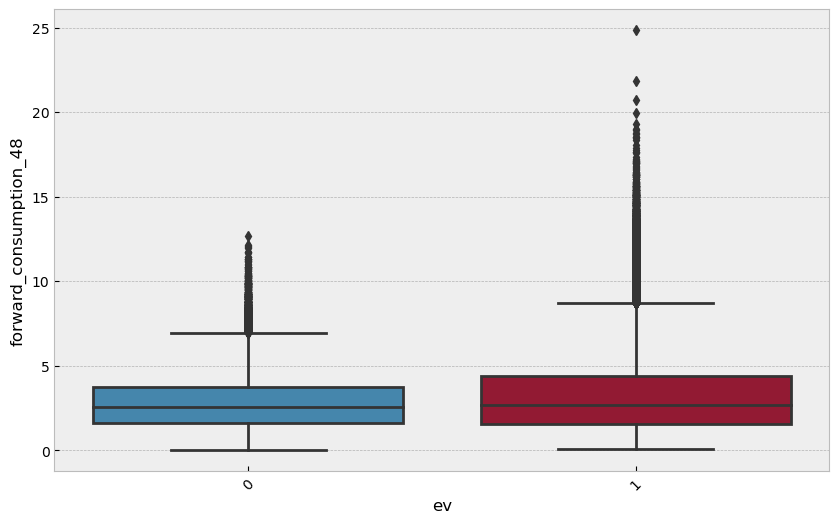

In [28]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x='ev', y="forward_consumption_48", data=df)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)
plt.show()

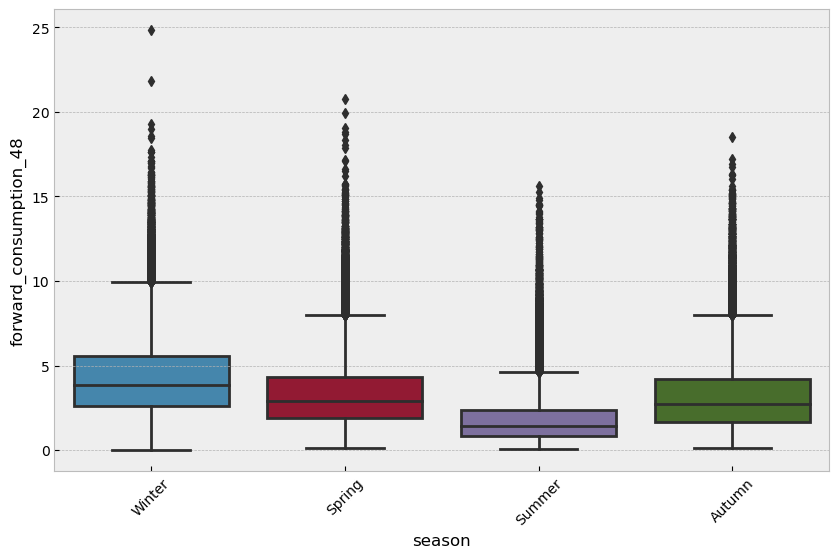

In [29]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x='season', y="forward_consumption_48", data=df)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)
plt.show()

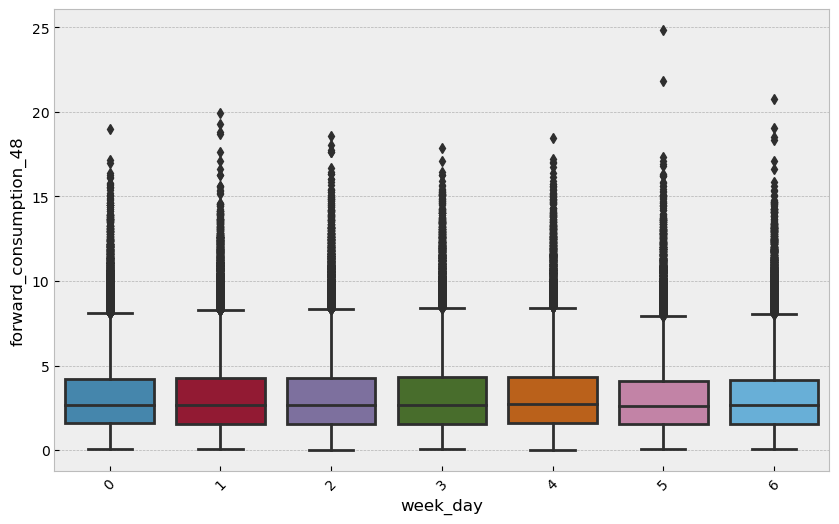

In [30]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x='week_day', y="forward_consumption_48", data=df)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)
plt.show()

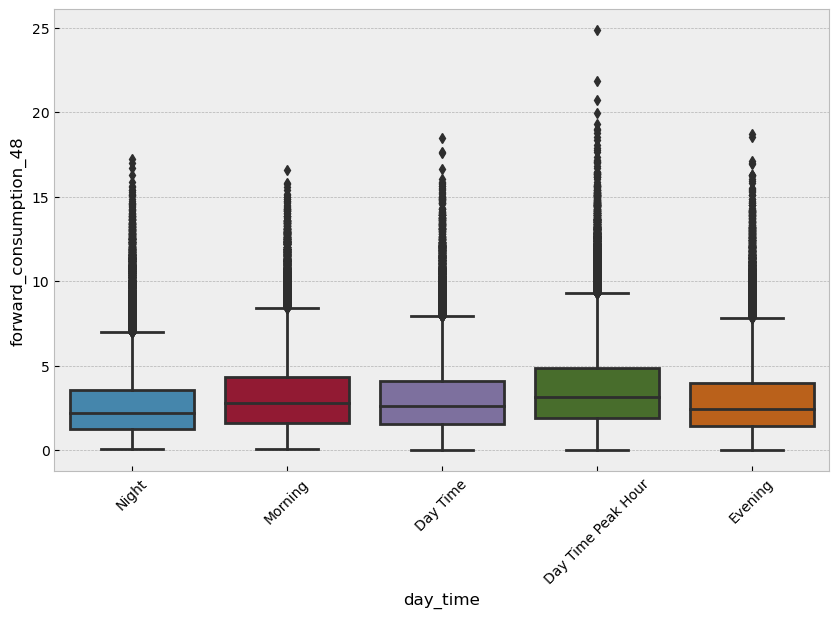

In [31]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x='day_time', y="forward_consumption_48", data=df)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# [23,0,1,2] - Night
# [3,4] - Late Night
# [5,6,7,8]  - Early Morning
# [9,10,11,12,13,14] - Day Time
# [15,16,17,18,19,20] - Day Time Peak Hour
# [20,21,22] - Evening

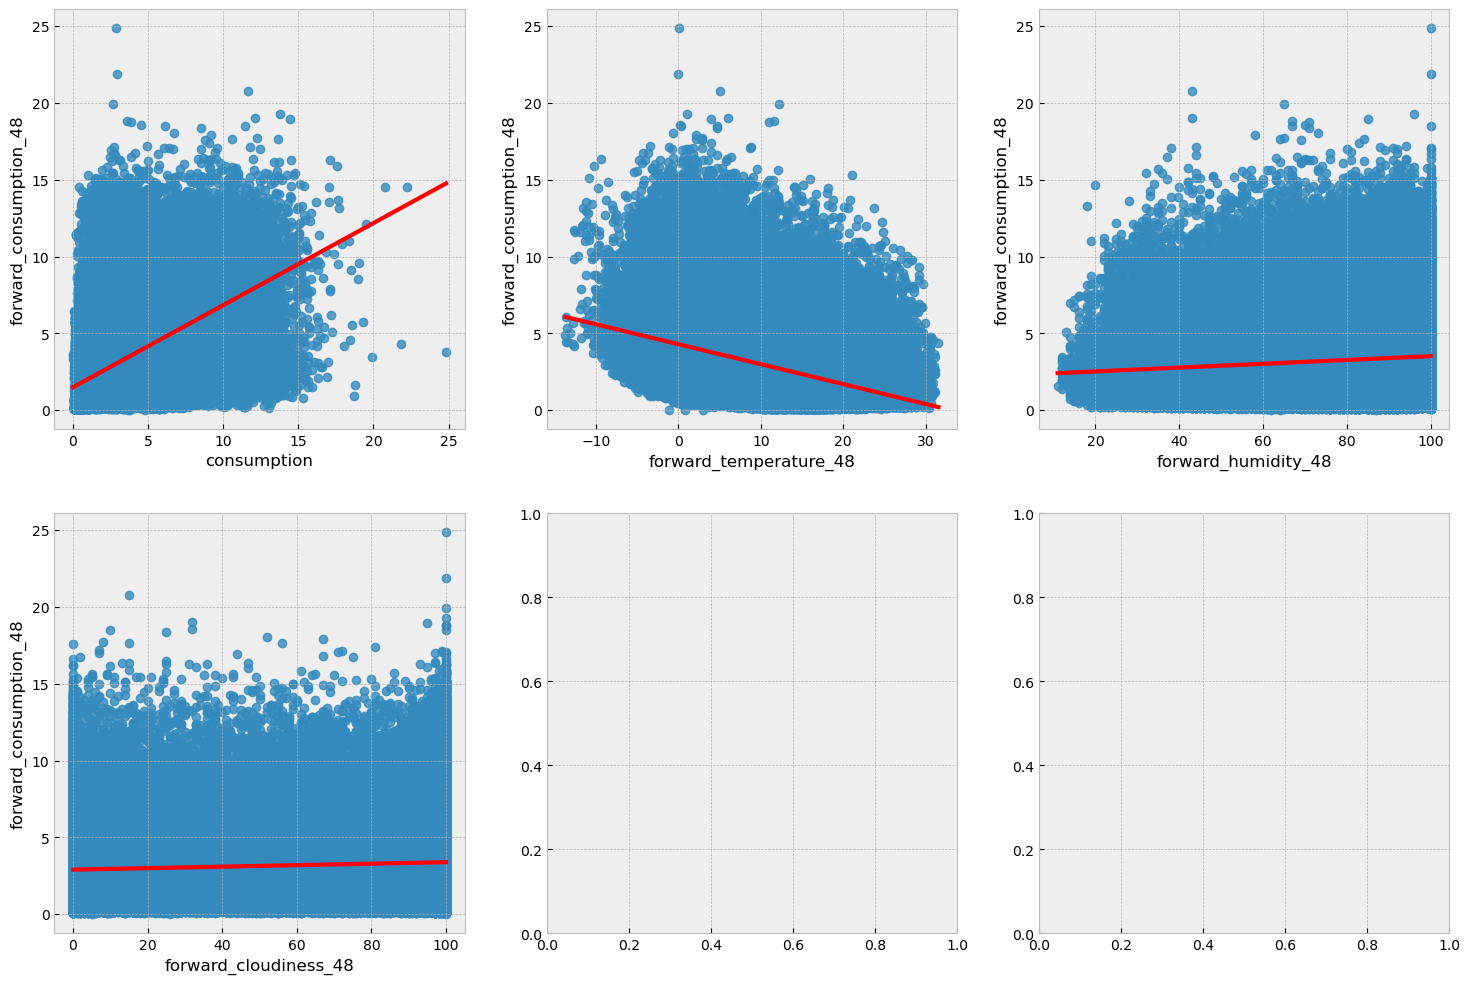

In [37]:
for col in df.columns:
    if col not in  ["season","day_time"]:
        df[col] = df[col].astype(float)
        
features_to_analyse = [
                       'consumption',
                       'forward_temperature_48',
                       'forward_humidity_48',
                       'forward_cloudiness_48',
                       'season'
                      ]

# Understand Linear relationship in between target vs features/ Note for lr y-will needed ot be transformed
fig, ax = plt.subplots(2, 3, figsize = (18, 12))

for i, ax in enumerate(fig.axes):
    if i < len(features_to_analyse) - 1:
        sns.regplot(x=features_to_analyse[i],
                    y='forward_consumption_48',
                    data=df,
                    ax=ax,
                    ci=95,
                    line_kws={"color": "red"},
                    scatter=True,
                    fit_reg=True,
                    n_boot=100)

<AxesSubplot:>

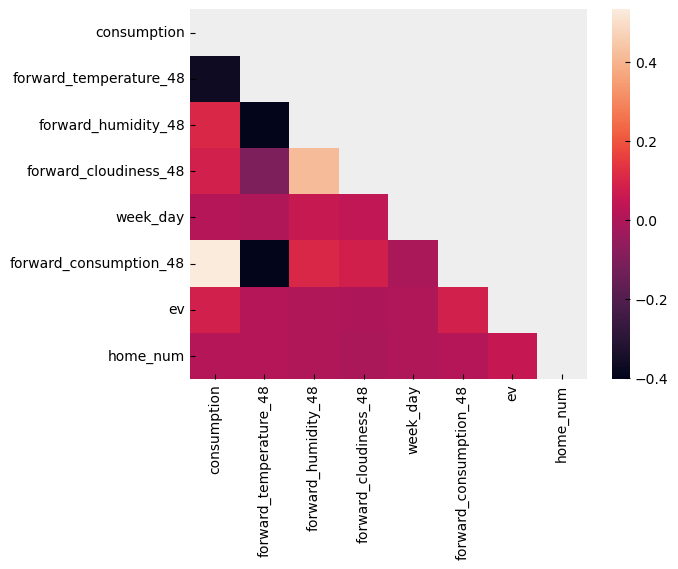

In [38]:
corr = df.corr(method='pearson')
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask = mask)

<AxesSubplot:>

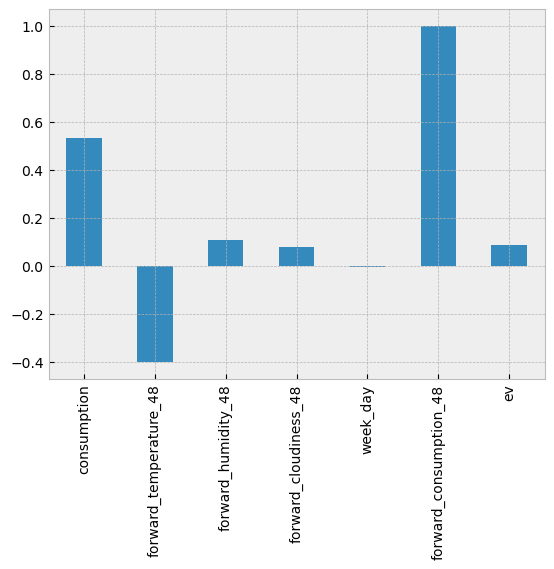

In [39]:
corr = df.corr(method='pearson')
corr['forward_consumption_48'].iloc[:-1].plot.bar()